In [1]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
import pandas as pd
import numpy as np

In [2]:
spark=SparkSession.builder\
    .master("local[*]")\
    .appName("C2")\
    .getOrCreate()

In [3]:
sc=spark.sparkContext

In [4]:
data=sc.textFile("C2.txt")

In [5]:
from numpy import array
data = data.map(lambda line: [float(x) for x in line.split('\t')]).cache() 

In [6]:
df = spark.createDataFrame(data,["x","y"])
df.show()

+-----+-----+
|    x|    y|
+-----+-----+
|15.55|28.65|
| 14.9|27.55|
|14.45|28.35|
|14.15| 28.8|
|13.75|28.05|
|13.35|28.45|
| 13.0|29.15|
|13.45| 27.5|
| 13.6| 26.5|
| 12.8|27.35|
| 12.4|27.85|
| 12.3| 28.4|
| 12.2|28.65|
| 13.4| 25.1|
|12.95|25.95|
| 12.9| 26.5|
|11.85| 27.0|
|11.35| 28.0|
|11.15| 28.7|
|11.25| 27.4|
+-----+-----+
only showing top 20 rows



In [7]:
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols=["x", "y"], outputCol="features")
new_df = vecAssembler.transform(df)
new_df.show()

+-----+-----+-------------+
|    x|    y|     features|
+-----+-----+-------------+
|15.55|28.65|[15.55,28.65]|
| 14.9|27.55| [14.9,27.55]|
|14.45|28.35|[14.45,28.35]|
|14.15| 28.8| [14.15,28.8]|
|13.75|28.05|[13.75,28.05]|
|13.35|28.45|[13.35,28.45]|
| 13.0|29.15| [13.0,29.15]|
|13.45| 27.5| [13.45,27.5]|
| 13.6| 26.5|  [13.6,26.5]|
| 12.8|27.35| [12.8,27.35]|
| 12.4|27.85| [12.4,27.85]|
| 12.3| 28.4|  [12.3,28.4]|
| 12.2|28.65| [12.2,28.65]|
| 13.4| 25.1|  [13.4,25.1]|
|12.95|25.95|[12.95,25.95]|
| 12.9| 26.5|  [12.9,26.5]|
|11.85| 27.0| [11.85,27.0]|
|11.35| 28.0| [11.35,28.0]|
|11.15| 28.7| [11.15,28.7]|
|11.25| 27.4| [11.25,27.4]|
+-----+-----+-------------+
only showing top 20 rows



kmeans++

In [8]:
cost = np.zeros(25)
K = range(2, 25)
for k in K:
    pkm = KMeans(initMode='k-means||').setK(k).setSeed(1).setFeaturesCol("features")
    model = pkm.fit(new_df)
    cost[k] = model.summary.trainingCost

Text(0.5, 1.0, 'Kmeans Cost C2')

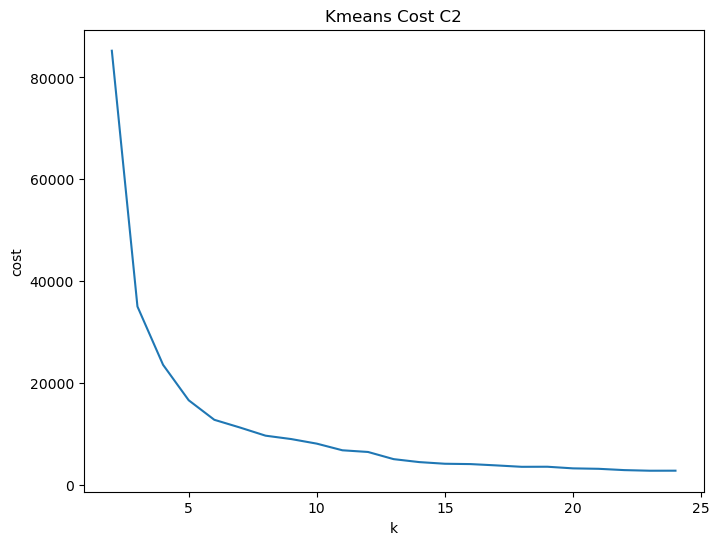

In [9]:
# plot cost-cluster diagram
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,25),cost[2:25])
ax.set_xlabel('k')
ax.set_ylabel('cost')
plt.title('Kmeans Cost C2')

In [10]:
k = 6
pkm = KMeans(initMode='k-means||').setK(k).setFeaturesCol("features")
model = pkm.fit(new_df)
centers = model.clusterCenters()
transformed=model.transform(new_df)
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[14.9165493   7.39647887]
[10.07759563 22.95163934]
[33.14095238  8.85904762]
[7.36858974 7.75705128]
[20.92561983  6.83305785]
[30.62735849 22.35754717]


In [11]:
dfcent = pd.DataFrame(centers, columns=['x', 'y'])
dfp = new_df.toPandas()
dfp=dfp.iloc[:, [0,1]].values
y_kmeans=transformed.toPandas()['prediction']

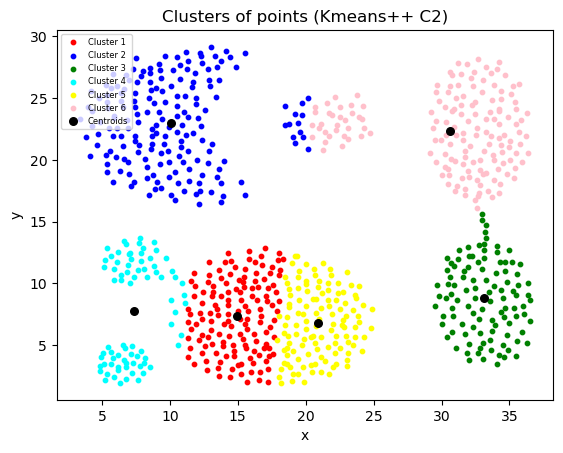

In [12]:
#6 Visualising the clusters
plt.scatter(dfp[y_kmeans==0, 0], dfp[y_kmeans==0, 1], s=10, c='red', label ='Cluster 1')
plt.scatter(dfp[y_kmeans==1, 0], dfp[y_kmeans==1, 1], s=10, c='blue', label ='Cluster 2')
plt.scatter(dfp[y_kmeans==2, 0], dfp[y_kmeans==2, 1], s=10, c='green', label ='Cluster 3')
plt.scatter(dfp[y_kmeans==3, 0], dfp[y_kmeans==3, 1], s=10, c='cyan', label ='Cluster 4')
plt.scatter(dfp[y_kmeans==4, 0], dfp[y_kmeans==4, 1], s=10, c='yellow', label ='Cluster 5')
plt.scatter(dfp[y_kmeans==5, 0], dfp[y_kmeans==5, 1], s=10, c='pink', label ='Cluster 6')


plt.scatter(dfcent['x'], dfcent['y'], s=30, c='black', label = 'Centroids')
plt.title('Clusters of points (Kmeans++ C2)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc=2,prop={'size': 6})
plt.show()

BisectingKMeans

In [13]:
from pyspark.ml.clustering import BisectingKMeans
cost = np.zeros(25)
K = range(2, 25)
for k in K:
    pkm = BisectingKMeans().setK(k).setFeaturesCol("features")
    model = pkm.fit(new_df)
    cost[k] = model.summary.trainingCost

Text(0.5, 1.0, 'BisectingKMeans Cost C2')

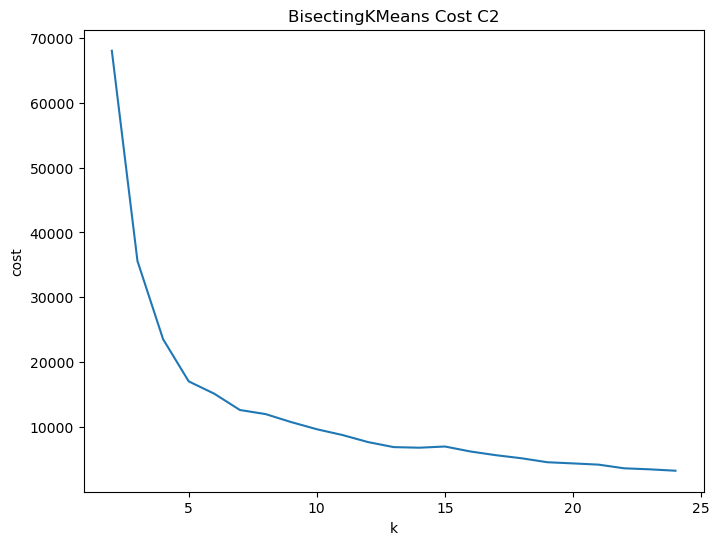

In [14]:
# plot cost-cluster diagram
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,25),cost[2:25])
ax.set_xlabel('k')
ax.set_ylabel('cost')
plt.title('BisectingKMeans Cost C2')

In [15]:
k = 7
pkm = BisectingKMeans().setK(k).setFeaturesCol("features")
model = pkm.fit(new_df)
centers = model.clusterCenters()
transformed=model.transform(new_df)
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[9.92969925 7.37894737]
[18.95527638  7.04472362]
[ 8.38451327 20.72123894]
[12.62402597 25.58181818]
[32.82247706  8.83119266]
[22.56       23.07166667]
[32.69251969 22.18897638]


In [16]:
dfcent = pd.DataFrame(centers, columns=['x', 'y'])
dfp = new_df.toPandas()
dfp=dfp.iloc[:, [0,1]].values
y_kmeans=transformed.toPandas()['prediction']

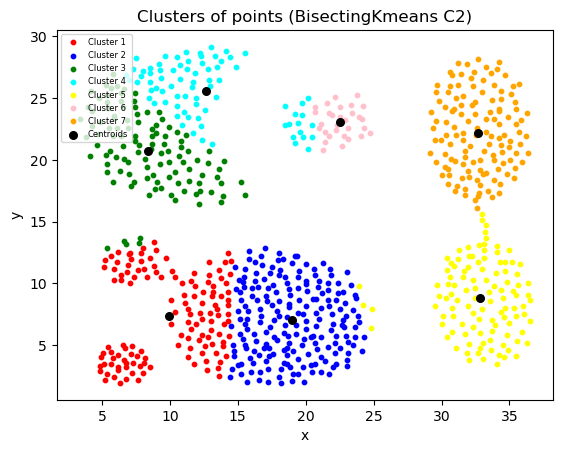

In [17]:
#6 Visualising the clusters
plt.scatter(dfp[y_kmeans==0, 0], dfp[y_kmeans==0, 1], s=10, c='red', label ='Cluster 1')
plt.scatter(dfp[y_kmeans==1, 0], dfp[y_kmeans==1, 1], s=10, c='blue', label ='Cluster 2')
plt.scatter(dfp[y_kmeans==2, 0], dfp[y_kmeans==2, 1], s=10, c='green', label ='Cluster 3')
plt.scatter(dfp[y_kmeans==3, 0], dfp[y_kmeans==3, 1], s=10, c='cyan', label ='Cluster 4')
plt.scatter(dfp[y_kmeans==4, 0], dfp[y_kmeans==4, 1], s=10, c='yellow', label ='Cluster 5')
plt.scatter(dfp[y_kmeans==5, 0], dfp[y_kmeans==5, 1], s=10, c='pink', label ='Cluster 6')
plt.scatter(dfp[y_kmeans==6, 0], dfp[y_kmeans==6, 1], s=10, c='orange', label ='Cluster 7')

plt.scatter(dfcent['x'], dfcent['y'], s=30, c='black', label = 'Centroids')
plt.title('Clusters of points (BisectingKmeans C2)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc=2,prop={'size': 6})
plt.show()

In [30]:
import time
list=[]
for i in range(1,5):
    j=1
    start_time = time.time()
    spark=SparkSession.builder.master("local["+str(j)+"]").appName("C2").getOrCreate()
    sc=spark.sparkContext
    data=sc.textFile("C2.txt")
    from numpy import array
    data = data.map(lambda line: [float(x) for x in line.split('\t')]).cache()
    df = spark.createDataFrame(data,["x","y"])
    vecAssembler = VectorAssembler(inputCols=["x", "y"], outputCol="features")
    new_df = vecAssembler.transform(df)
    k = 6
    pkm = KMeans(initMode='k-means||').setK(k).setFeaturesCol("features")
    model = pkm.fit(new_df)
    print("The number of cores: ",i,", Execution time: ","%s seconds" % (time.time() - start_time))
    list.append((time.time() - start_time))

The number of cores:  1 , Execution time:  1.1145029067993164 seconds
The number of cores:  2 , Execution time:  0.9857139587402344 seconds
The number of cores:  3 , Execution time:  1.0597114562988281 seconds
The number of cores:  4 , Execution time:  1.03309965133667 seconds


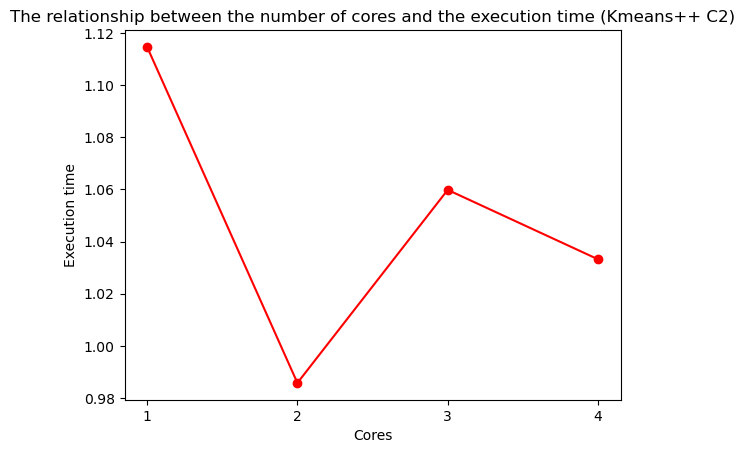

In [31]:
import matplotlib.pyplot as plt
core = ['1','2','3','4']
plt.plot(core, list,marker = 'o',c='red')
plt.xlabel('Cores')
plt.ylabel('Execution time')
plt.title('The relationship between the number of cores and the execution time (Kmeans++ C2)')
plt.show()

In [32]:
import time
list=[]
for i in range(1,5):
    j=1
    start_time = time.time()
    spark=SparkSession.builder.master("local["+str(j)+"]").appName("C2").getOrCreate()
    sc=spark.sparkContext
    data=sc.textFile("C2.txt")
    from numpy import array
    data = data.map(lambda line: [float(x) for x in line.split('\t')]).cache()
    df = spark.createDataFrame(data,["x","y"])
    vecAssembler = VectorAssembler(inputCols=["x", "y"], outputCol="features")
    new_df = vecAssembler.transform(df)
    k = 7
    pkm = BisectingKMeans().setK(k).setFeaturesCol("features")
    model = pkm.fit(new_df)
    print("The number of cores: ",i,", Execution time: ","%s seconds" % (time.time() - start_time))
    list.append((time.time() - start_time))

The number of cores:  1 , Execution time:  2.1843533515930176 seconds
The number of cores:  2 , Execution time:  2.163527488708496 seconds
The number of cores:  3 , Execution time:  2.100834369659424 seconds
The number of cores:  4 , Execution time:  2.031015396118164 seconds


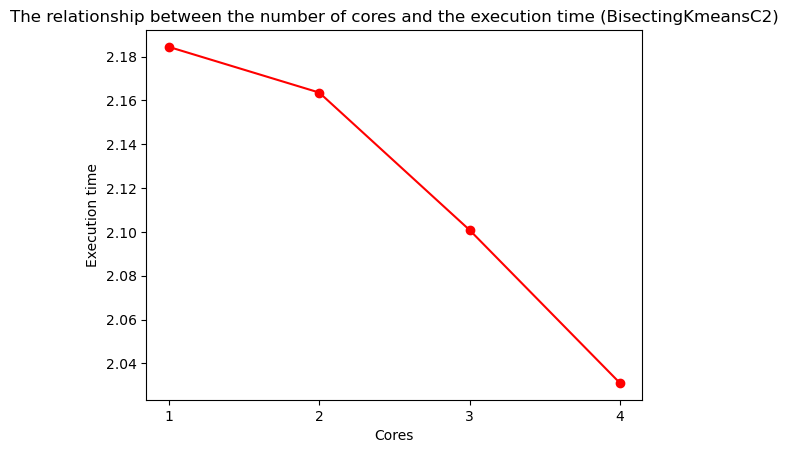

In [33]:
import matplotlib.pyplot as plt
core = ['1','2','3','4']
plt.plot(core, list,marker = 'o',c='red')
plt.xlabel('Cores')
plt.ylabel('Execution time')
plt.title('The relationship between the number of cores and the execution time (BisectingKmeansC2)')
plt.show()